## Understanding business case  problems

![Elo](https://www.cloudera.com/content/dam/www/marketing/images/logos/customers/cartao-elo.png)

[Elo](https://www.cartaoelo.com.br/), 
 Elo là một trong những thương hiệu hàng đầu và có thể coi là mạnh nhất trong thanh toán trực tuyển ở Brazil, tâp đoàn này đã tiến hành một dứ án lớn với tập đoàn Merchant để đưa ra nhiều mức phí giảm giá cho khách hàng của Merchant nếu họ sử dụng thẻ thanh toán của Elo. Tuy nhiên vấn đề là khi liên kết như vậy, đối với khách hàng của Merchant chưa chắc đã thích sử dụng thẻ thanh toán của Elo. Bởi vì Elo vẫn còn mới mẻ với họ, hoặc có thể họ vẫn đang muốn dùng những thẻ cũ của các công ty khác và họ có thể ngại thay đổi. Do đó chiến lược của Elo là sẽ cung cấp các discount cho khách hàng của Merchant và sẽ xem xét sự thay đổi trong hành vi của khách hàng của Merchant, những khách hàng nào có dấu hiệu sẽ dùng nhiều sản phẩm của họ. từ đó họ có thể tập trung vào những khách hàng đó. <br>
 Đối với bài toán này ta sẽ xây dựng một mô hình recommeder system với target là dự báo độ loyalty của khách hàng. OKe Now let go
 
 
 
## Import library and doing an extensive exploratory data analysis + feature engineering

In [3]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

### Dataset Exploration

In [1]:
!ls ../input/

Data_Dictionary.xlsx	     new_merchant_transactions.csv  train.csv
historical_transactions.csv  sample_submission.csv
merchants.csv		     test.csv


Chúng ta sẽ đi vào chi tiết các tập dữ liệu

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
* historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
* merchants.csv - additional information about all merchants / merchant_ids in the dataset.
* new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

xem qua train and test set.

In [4]:
train_df = pd.read_csv("../input/train.csv", parse_dates=["first_active_month"])
test_df = pd.read_csv("../input/test.csv", parse_dates=["first_active_month"])
print("Number of rows and columns in train set : ",train_df.shape)
print("Number of rows and columns in test set : ",test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [5]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


### Target Column Exploration:
### Target ở đây có nghĩa là độ trung thành (loyalty_score) của các khách hàng của Merchant

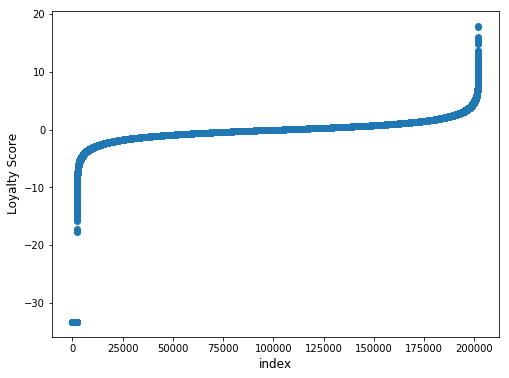

In [6]:
target_col = "target"

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

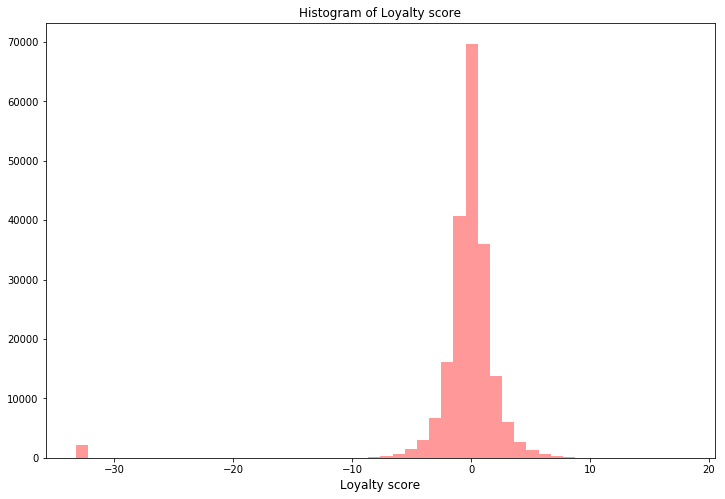

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

Ta thấy có một số target nằm tách biệt ra hẳn khỏi vùng trung tâm đây là các outliers, hãy xem xét kĩ hơn

In [8]:
(train_df[target_col]<-30).sum()

2207

Có khoản 2207 khách hàng trong outlier như vậy chiếm khoảng 1% tổng khách hàng, tuy nhiên ta cũng chưa thể xóa số khách hàng này đi dc, vì có thể thực tế họ có những thuộc tính đặc biết khiến độ trung thàng thấp như thế,  ta sẽ làm rõ hơn ở phía sau 

### First Active Month

Ta sẽ xem sự phân phối của train và test set

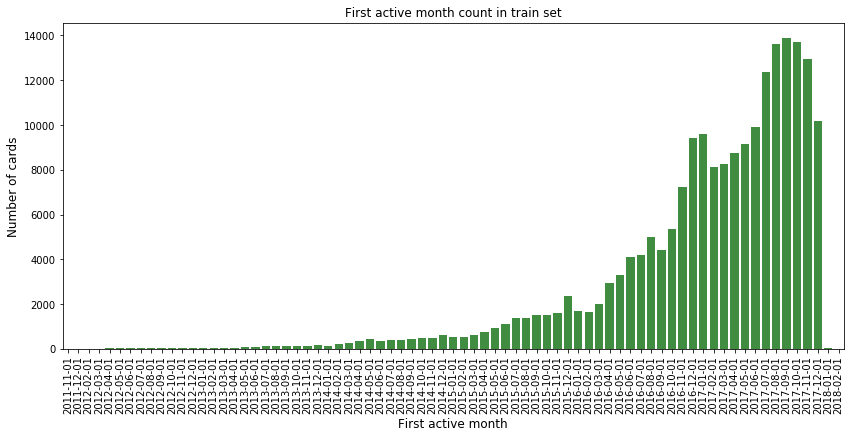

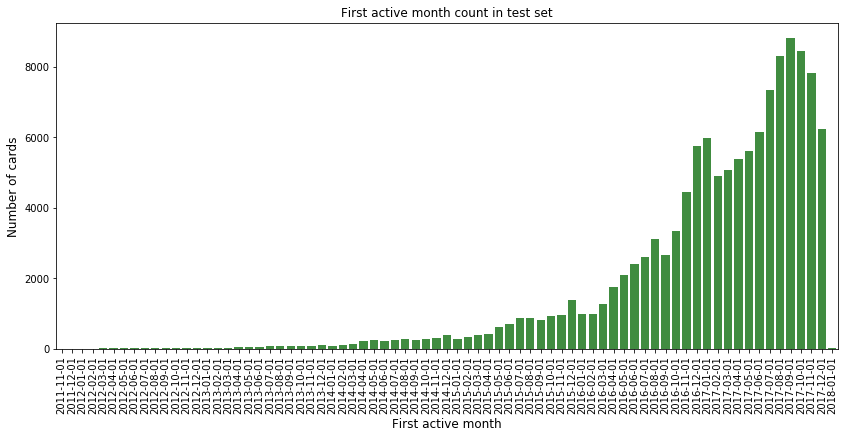

In [9]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

Ta thấy giữa trainset và test set có sư tương đồng trong phân phối, điều nay sẽ giúp ta dễ dàng hơn trong việc xây dựng mô hình

### Feature 1,2 & 3:

Chúng ta sẽ visualize sự tương quan giữa feature với target column

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



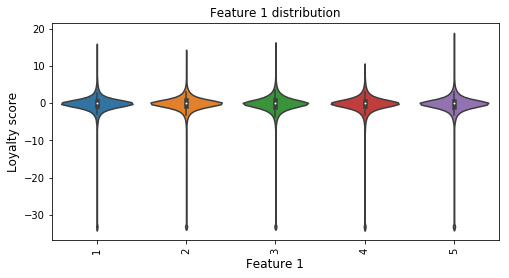

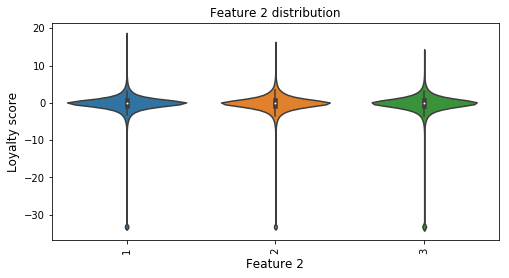

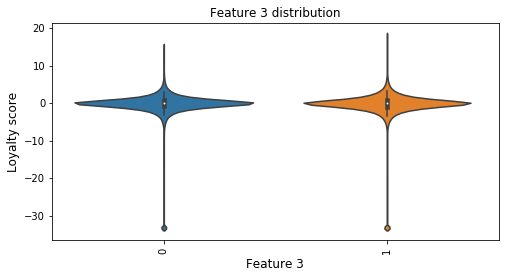

In [11]:
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

### Historical Transactions:

bây giờ sẽ là Historical transactions dataset

In [12]:
hist_df = pd.read_csv("../input/historical_transactions.csv")
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [13]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [14]:
cnt_srs = train_df.groupby("num_hist_transactions")[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Histtranscnt")

Ta sẽ chia giá trị ở cột num_hist_transactions thành các bins, ở đây ta chia thành 12 bins

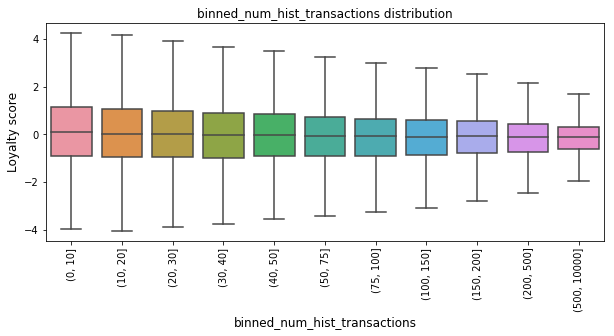

In [17]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(10,4))
sns.boxplot(x="binned_num_hist_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

In [18]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

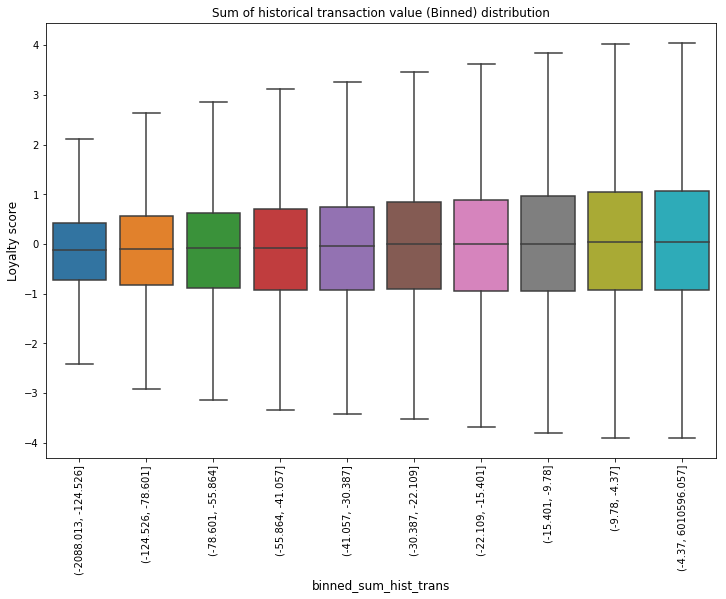

In [19]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

Ta thấy độ trung thành của các khách hàng tăng dần theo chiều tăng của binned_sum_hist_trans, điều này dễ hiểu khi 1 khách càng có nhiều thói quen dùng thẻ đó trong quá khứ thì dĩ nhiên độ trung thành của họ sẽ tăng theo thời gian, thật khó để họ từ bỏ chiếc thẻ bên mình chỉ khi hãng thẻ thanh toán khác cung cấp một sự discount hoặc sản phẩm tốt hơn hẳn

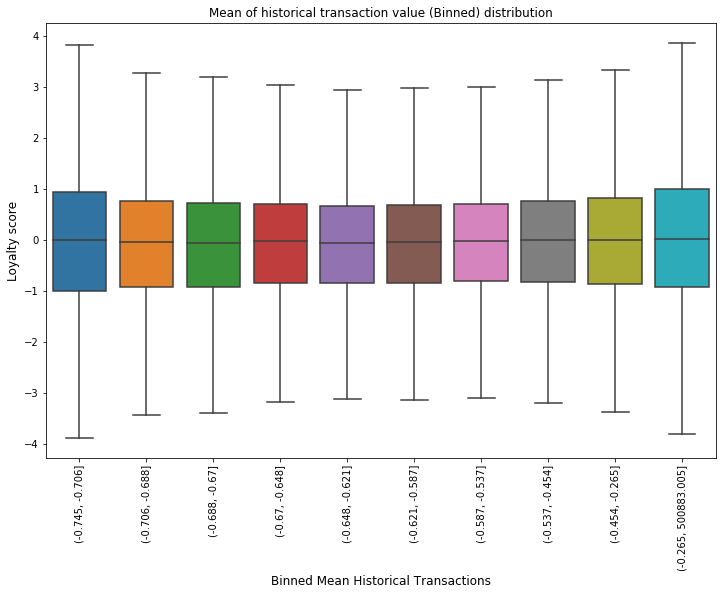

In [20]:
bins = np.percentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_mean_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

### New Merchant Transactions

Đây là tập dataset newmerchant transactions

In [21]:
new_trans_df = pd.read_csv("../input/new_merchant_transactions.csv")
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [22]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

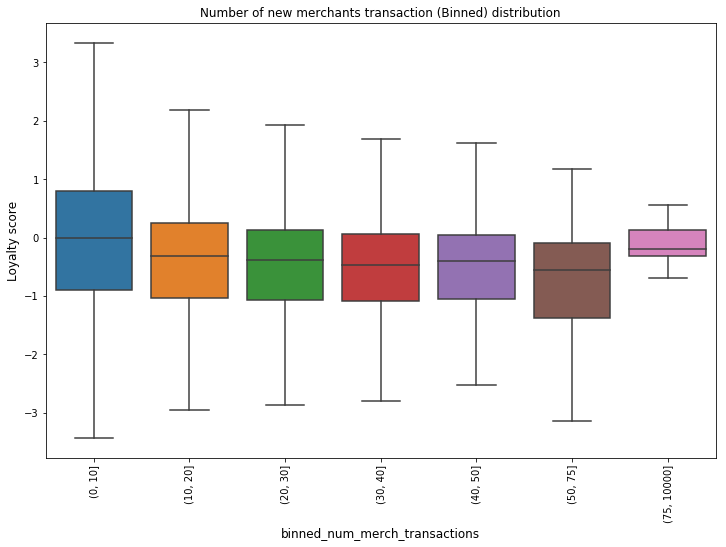

In [23]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_merch_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Number of new merchants transaction (Binned) distribution")
plt.show()

Loyalty score seem to decrease as the number of new merchant transactions increases except for the last bin. 

In [24]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

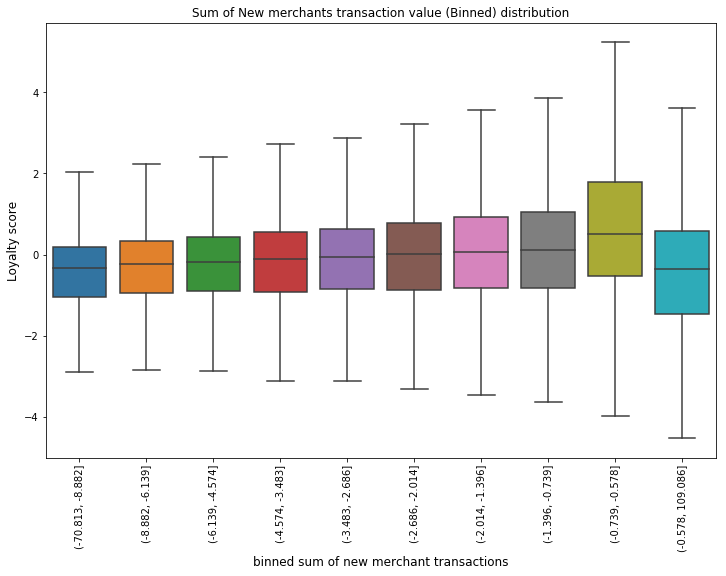

In [25]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

Loyalty scores seem to increase with the increase in the sum of new merchant transaction values but for the last bin.

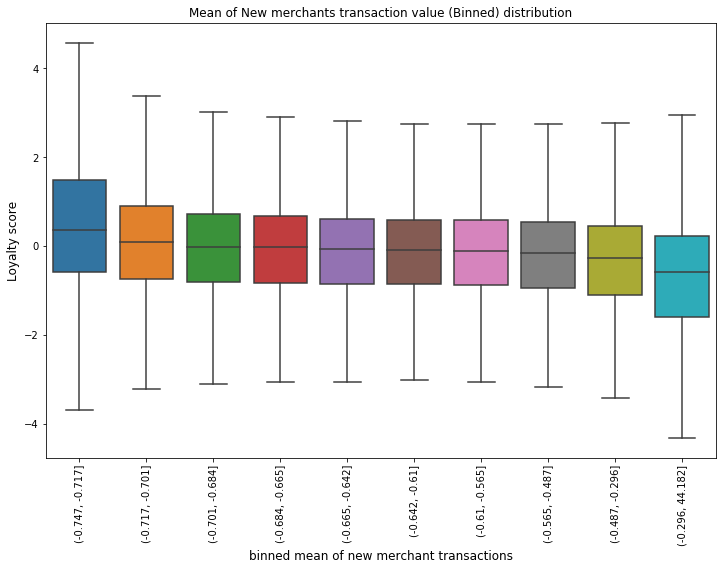

In [26]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

### Baseline Model

chúng ta sẽ xây dựng một baseline model dựa trên các dataset đã làm sạch ở trên

In [27]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans",
              ]

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.
    

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.81049
[200]	valid_0's rmse: 3.80984
Early stopping, best iteration is:
[163]	valid_0's rmse: 3.80946
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75935
[200]	valid_0's rmse: 3.75958
Early stopping, best iteration is:
[151]	valid_0's rmse: 3.75848
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.80311
[200]	valid_0's rmse: 3.80228
[300]	valid_0's rmse: 3.80269
Early stopping, best iteration is:
[210]	valid_0's rmse: 3.80206
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.7929
[200]	valid_0's rmse: 3.79349
Early stopping, best iteration is:
[145]	valid_0's rmse: 3.79269
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.8547
[200]	valid_0's rmse: 3.85516
Early stopping, best iteration is:
[127]	valid_0's rmse: 3.85456


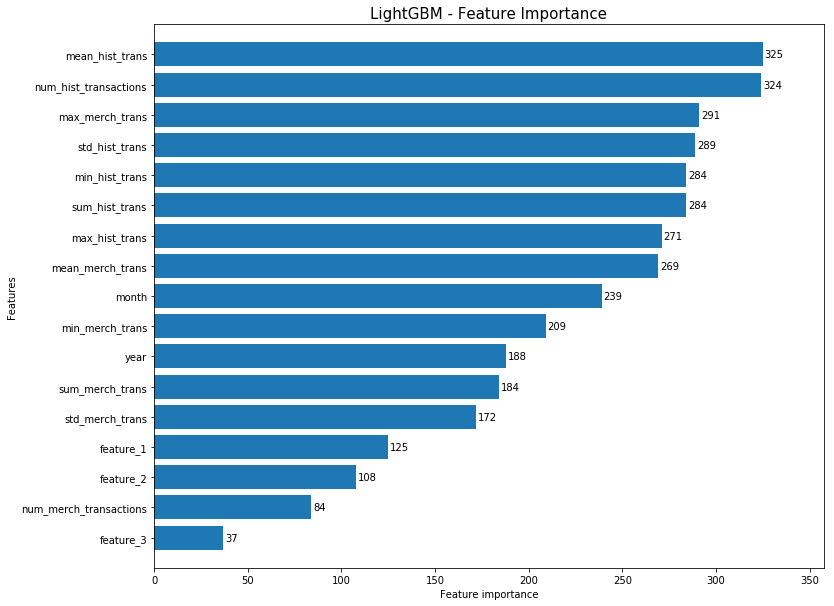

In [28]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [29]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

Như vậy ta đã đưa ra được dự báo cho độ trung thành của các khách hàng tương lai của merchant ở tập test set, ta lưu lại tập này ở file baseline_lgb.csv và tiến hành submit ở leaderboard